In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import scanpy.external as sce

In [2]:
%%time
adata = sc.read_h5ad("Kuppe_et_al_snRNA.h5ad")
adata

CPU times: user 20.2 s, sys: 2.94 s, total: 23.1 s
Wall time: 23.1 s


AnnData object with n_obs × n_vars = 191795 × 28975
    obs: 'sample', 'n_counts', 'n_genes', 'percent_mito', 'doublet_score', 'dissociation_score', 'cell_type_original', 'patient_region_id', 'donor_id', 'patient_group', 'major_labl', 'final_cluster', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'X_approximate_distribution', 'batch_condition', 'cell_type_original_colors', 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [3]:
adata.obs.disease

AAACCCACAAAGGAGA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1                   normal
AAACCCACAGAGATGC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1                   normal
AAACCCAGTAACGGTG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1                   normal
AAACCCAGTCCAGAAG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1                   normal
AAACCCAGTCGTCGGT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1                   normal
                                                          ...          
TTTCATGGTCTTGCTC-1                                myocardial infarction
TTTCCTCAGGTTCATC-1                                myocardial infarction
TTTCGATTCCGGTAAT-1                                myocardial infarction
TTTGACTTCGCCAACG-1                                myocardial infarction
TTTGGTTGTGCCCAGT-1                                myocardial infarction
Name: disease, Length: 191795, dtype: category
Categories (2, object): ['myocardial infarction', 'normal']

In [4]:
adata.obs.patient_group

AAACCCACAAAGGAGA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1    myogenic
AAACCCACAGAGATGC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1    myogenic
AAACCCAGTAACGGTG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1    myogenic
AAACCCAGTCCAGAAG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1    myogenic
AAACCCAGTCGTCGGT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1    myogenic
                                                    ...   
TTTCATGGTCTTGCTC-1                                ischemic
TTTCCTCAGGTTCATC-1                                ischemic
TTTCGATTCCGGTAAT-1                                ischemic
TTTGACTTCGCCAACG-1                                ischemic
TTTGGTTGTGCCCAGT-1                                ischemic
Name: patient_group, Length: 191795, dtype: category
Categories (3, object): ['fibrotic', 'ischemic', 'myogenic']

In [5]:
adata.obs.donor_id

AAACCCACAAAGGAGA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1     P1
AAACCCACAGAGATGC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1     P1
AAACCCAGTAACGGTG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1     P1
AAACCCAGTCCAGAAG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1     P1
AAACCCAGTCGTCGGT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1     P1
                                                 ... 
TTTCATGGTCTTGCTC-1                                P16
TTTCCTCAGGTTCATC-1                                P16
TTTCGATTCCGGTAAT-1                                P16
TTTGACTTCGCCAACG-1                                P16
TTTGGTTGTGCCCAGT-1                                P16
Name: donor_id, Length: 191795, dtype: category
Categories (20, object): ['P1', 'P2', 'P3', 'P4', ..., 'P17', 'P18', 'P19', 'P20']

#### The disease state is called "MI" for all of the diseased patients, but per Supplemental Table 1, it turns out that some of these donors are actually ICM.

In [6]:
donor_info_df = pd.read_csv("Kuppe_supplemental_Table_1.csv")
donor_info_df.head()

,patient,region_novel,patient_region_id,region_zone_description,age (years),gender,sampling location (segment area 17-model AHA),infarction location,days after infarction,disease,pathologists description HE staining cryo section,donor information,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,P1,control,control_P1,CTRL,44,m,LV free wall,n.a.,control,control,Normal myocardium,NaN,NaN,NaN,NaN
1,P17,control,control_P17,CTRL,61,m,LV free wall,n.a.,control,control,Normal myocardium,NaN,NaN,NaN,NaN
2,P7,control,control_P7,CTRL,55,f,LV free wall,n.a.,control,control,Normal myocardium,declined for transplation due to CAD,NaN,NaN,NaN
3,P8,control,control_P8,CTRL,44,m,LV free wall,n.a.,control,control,Normal myocardium,declined due to calcified aortic valves,NaN,NaN,NaN
4,P14,FZ,FZ_P14,FZ,59,m,LV APEX,anterior LV,62,ICM,Young scar with fibroblasts and some collagen,NaN,NaN,NaN,NaN


In [7]:
donor_info_df = donor_info_df[["patient", "disease"]].drop_duplicates().reset_index(drop=True)
donor_info_df

,patient,disease
0,P1,control
1,P17,control
2,P7,control
3,P8,control
4,P14,ICM
5,P18,ICM
6,P20,ICM
7,P19,ICM
8,P4,ICM
9,P13,ICM


#### As we don't know much about the heart failure status of P5 (CAD, HF), we will drop this patient

In [8]:
# confirm that these adata and the donor_ids in this Supplemental Table overlap
print(f"Overlapping: {len(set(adata.obs.donor_id) & set(donor_info_df.patient))}")
print(f"Overlapping: {len(set(adata.obs.donor_id) - set(donor_info_df.patient))}")
print(f"Overlapping: {len(set(donor_info_df.patient) - set(adata.obs.donor_id))}")

Overlapping: 20
Overlapping: 0
Overlapping: 3


In [9]:
(set(donor_info_df.patient) - set(adata.obs.donor_id))

{'P21', 'P22', 'P23'}

Based on Supplemental Table 2 and Supplemental Table 3, it seems like P21, P22, and P23 were somehow not used in the snRNA-seq or snATAC-seq samples

### Merge this disease information to the adata

In [10]:
adata.obs.shape

(191795, 32)

In [11]:
new_metadata = adata.obs.reset_index().merge(donor_info_df, left_on = "donor_id", right_on = "patient", how = "inner")
new_metadata.shape

(191795, 35)

In [12]:
# keep the relevant metadata
new_metadata = new_metadata[['cell_type_original', 'sex', 'donor_id', 'development_stage', 'disease_y', 'index']]
new_metadata.index = new_metadata['index']
new_metadata = new_metadata.drop(columns = ['index'])
new_metadata.head()

,cell_type_original,sex,donor_id,development_stage,disease_y
index,,,,,
AAACCCACAAAGGAGA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Fibroblast,male,P1,44-year-old human stage,control
AAACCCACAGAGATGC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Cardiomyocyte,male,P1,44-year-old human stage,control
AAACCCAGTAACGGTG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Cardiomyocyte,male,P1,44-year-old human stage,control
AAACCCAGTCCAGAAG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Fibroblast,male,P1,44-year-old human stage,control
AAACCCAGTCGTCGGT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Cardiomyocyte,male,P1,44-year-old human stage,control


In [13]:
# for later consistency, change the column names
new_metadata = new_metadata.rename(columns={'cell_type_original': 'cell_type', 
                                                'development_stage': 'age'})

# To extract just the integer age, remove the '-year-old-human-stage' from the age string
new_metadata['age'] = new_metadata['age'].str.extract(r'(\d+)').astype(int)

# add additional columns
new_metadata['study'] = 'Kuppe 2022'
new_metadata['technology'] = '3prime-v3'
new_metadata['cell_or_nuclei'] = 'Nuclei'
new_metadata['region'] = 'LV'

In [14]:
new_metadata.disease_y.unique()

array(['control', 'CAD, HF', 'AMI', 'ICM'], dtype=object)

In [15]:
new_metadata['disease'] = new_metadata['disease_y'].map(
    {
        "control": "ND",
        "CAD, HF": "CAD, HF",
        "AMI": "AMI",
        "ICM": "ICM"
    }
)

new_metadata = new_metadata.drop(columns = "disease_y")

In [16]:
new_metadata.head()

,cell_type,sex,donor_id,age,study,technology,cell_or_nuclei,region,disease
index,,,,,,,,,
AAACCCACAAAGGAGA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Fibroblast,male,P1,44,Kuppe 2022,3prime-v3,Nuclei,LV,ND
AAACCCACAGAGATGC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Cardiomyocyte,male,P1,44,Kuppe 2022,3prime-v3,Nuclei,LV,ND
AAACCCAGTAACGGTG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Cardiomyocyte,male,P1,44,Kuppe 2022,3prime-v3,Nuclei,LV,ND
AAACCCAGTCCAGAAG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Fibroblast,male,P1,44,Kuppe 2022,3prime-v3,Nuclei,LV,ND
AAACCCAGTCGTCGGT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Cardiomyocyte,male,P1,44,Kuppe 2022,3prime-v3,Nuclei,LV,ND


In [19]:
# reorder the adata to the metadata order
adata = adata[new_metadata.index, :]

In [20]:
# add back to the adata 
adata.obs = new_metadata

In [21]:
# extract the raw counts 
adata = adata.raw.to_adata()

In [22]:
adata.X.sum(axis = 1)

matrix([[ 2597.],
        [12988.],
        [ 6358.],
        ...,
        [18578.],
        [ 1790.],
        [ 1339.]], dtype=float32)

In [23]:
adata.layers['counts'] = adata.X

#### Make sure that adata.var as gene symbols

In [24]:
# check that the vars are the gene symbols, not ENSEMBL id
adata.var_names

Index(['ENSG00000177613', 'ENSG00000128918', 'ENSG00000143977',
       'ENSG00000196177', 'ENSG00000244482', 'ENSG00000234426',
       'ENSG00000158578', 'ENSG00000133393', 'ENSG00000149091',
       'ENSG00000272444',
       ...
       'ENSG00000263711', 'ENSG00000245864', 'ENSG00000108946',
       'ENSG00000078246', 'ENSG00000229694', 'ENSG00000179152',
       'ENSG00000248174', 'ENSG00000249875', 'ENSG00000215251',
       'ENSG00000171858'],
      dtype='object', length=28975)

In [25]:
# as current the vars are the ENSEMBL_id, change them
adata.var['ensembl_id'] = adata.var.index
adata.var.index = adata.var.feature_name.astype(str)
adata.var = adata.var.drop(columns = ["feature_name"])

In [26]:
adata.obs.cell_type.unique()

['Fibroblast', 'Cardiomyocyte', 'Endothelial', 'Myeloid', 'Neuronal', ..., 'Mast', 'Lymphoid', 'Cycling cells', 'vSMCs', 'Adipocyte']
Length: 11
Categories (11, object): ['Adipocyte', 'Cardiomyocyte', 'Cycling cells', 'Endothelial', ..., 'Myeloid', 'Neuronal', 'Pericyte', 'vSMCs']

In [27]:
adata.obs["consistent_cell_type"] = adata.obs["cell_type"].map(
    {
        "Adipocyte": "Adipocyte",
        "Cardiomyocyte": "Cardiomyocyte",
        "Cycling cells": "Myeloid",
        "Endothelial": "Endothelial",
        "Fibroblast": "Fibroblast",
        "Lymphoid": "Lymphoid",
        "Mast": "Mast",
        "Myeloid": "Myeloid",
        "Neuronal": "Neuronal",
        "Pericyte": "Pericyte",
        "vSMCs": "vSMC",
    }
)

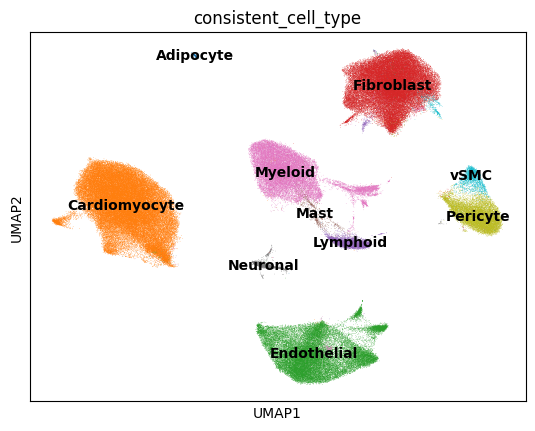

In [30]:
sc.pl.umap(adata, color = "consistent_cell_type", legend_loc = "on data")

In [31]:
adata.write("01_updated_Kuppe_all.h5ad")